# 1. Load Packages

In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
import anndata
import scanpy as sc
import os

import matplotlib.pyplot as plt


In [18]:
figure_folder = r'L:\Shiwei\RNA_MERFISH_analysis\Merged_nonclear'
print(figure_folder)
if not os.path.exists(figure_folder):
    os.makedirs(figure_folder)
    
    
sc.settings.n_jobs = 24
sc.settings.set_figure_params(dpi=150, dpi_save=300, frameon=False, 
                              figsize=(4, 4), fontsize=8, facecolor='white', transparent=True)
sc.settings.figdir = figure_folder

L:\Shiwei\RNA_MERFISH_analysis\Merged_nonclear


## 1.1 Load RNA MERFISH data for gene indexes 

**filtered_cluster_data** can be generated by the jupyter notebook from below:

[1_rna_merfish_preprocessing_and_clustering](1_rna_merfish_preprocessing_and_clustering.ipynb)

In [50]:
save_folder = r'L:\Shiwei\RNA_MERFISH_analysis\Merged_nonclear'
merged_adata = sc.read(os.path.join(save_folder,'filtered_cluster_data.h5ad'))

# 2. Load Meng's MERFISH and preprocess the data

## 2.1 load Meng's dataset
https://doi.org/10.1038/s41586-021-03705-x


In [20]:
from sklearn import preprocessing
#adata_mer = adata_mer

MOp_MERFISH_meng_preprocessed_for_integration_file =r'L:\Shiwei\RNA_MERFISH_analysis\Meng_data\counts.h5ad'

merfish_raw = sc.read_h5ad(MOp_MERFISH_meng_preprocessed_for_integration_file)

**cell_labels** can be found in the path below

[cell_labels_link](../resources/merfish_mop_2021/cell_labels.csv)

In [21]:
merfish_label = pd.read_csv(r'L:\Shiwei\RNA_MERFISH_analysis\Meng_data\cell_labels.csv', index_col=0)

In [22]:
merData = pd.DataFrame(merfish_raw.X, index = merfish_raw.obs.index, columns = merfish_raw.var.index)
labels = merfish_label.loc[merfish_label['label']!='-1']
# merge dataframes
merCluster=merData.merge(labels, how='inner', left_index=True, right_index=True)

In [23]:
from sklearn import preprocessing
# Scale variable measurements for model training
merGroupedDataZ = pd.DataFrame(preprocessing.scale(merCluster.iloc[:,:-5]),index = merCluster.iloc[:,:-5].index, columns = merCluster.iloc[:,:-5].columns)

merGroupedDataZ['subclass'] = merCluster.iloc[:,-2]

C:\Users\shiwei\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:174: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
C:\Users\shiwei\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:191: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


## 2.2 train classfier with Meng's dataset

### Train classifer de novo

In [24]:
adata_ref = merGroupedDataZ

# Train the classifer using the shared varibales
genes_from_ref = set(merData.columns)
genes = list(genes_from_ref.intersection(set(merged_adata.var.index)))

In [39]:
%%time
from sklearn.neural_network import MLPClassifier

# Train a classifier
gene_ids = [merData.columns.get_loc(g) for g in genes]

print('Train cell type classifier.')

X = np.array(adata_ref.iloc[:,:-1])[:, gene_ids]
Y = np.array(adata_ref['subclass'])
nnc = MLPClassifier(max_iter = 500)
nnc.fit(X, Y)

Train cell type classifier.
Wall time: 9min 32s


MLPClassifier(max_iter=500)

# Initial prediction

### 3.1 define functions

In [53]:
# Sorting code from Meng

from random import choice

def permuteOrder(df,axis,switch = 0):
    penaltyMat = np.zeros((df.shape[0],df.shape[1]))
    for i in range(penaltyMat.shape[0]):
        for j in range(penaltyMat.shape[1]):
            penaltyMat[i,j] = np.abs(i-(df.shape[0])/(df.shape[1])*j)**0.5
    if axis == 0:
        sort = df.index.values.copy()
    elif axis == 1:
        sort = df.columns.values.copy()
    dfCopy = df.values.copy()
#     print(dfCopy)
    for i in range(df.shape[int(axis)]):
        penalty = np.full((df.shape[int(axis)]),np.inf)
        for j in range(len(penalty)):
            tempMat = dfCopy.copy()
            if axis == 0:
                tempMat[[i, j],:] = tempMat[[j, i],:]
            elif axis == 1:
                tempMat[:,[i, j]] = tempMat[:,[j, i]]
            penalty[j] = sum(sum(tempMat*penaltyMat))
        idx = np.argmin(penalty)
        if not idx == i:                
            switch += 1
        if axis == 0:
            dfCopy[[i, idx], :] = dfCopy[[idx, i], :];
        elif axis == 1:
            dfCopy[:,[i, idx]] = dfCopy[:,[idx, i]];
        else:
            print('bad axis {}'.format(axis))
        sort[[i, idx]] = sort[[idx, i]]
    return switch,sort

def runPermutation(df, axis = 'Both', maxIter = 100,maxTrys = 9):  # initial maxTrys = 5
    iterations = 0
    trys = 0
    sortedDF = df.copy(deep=True)
    while iterations < maxIter:
        if axis == 'Both':
            switch,rowSort = permuteOrder(sortedDF,0)
            sortedDF = sortedDF.loc[rowSort,:].copy(deep=True)
            switch,columnSort = permuteOrder(sortedDF,1,switch)
            sortedDF = sortedDF.loc[:,columnSort].copy(deep=True)
            iterations += 1
            if switch == 0 and trys < maxTrys:
                currentIndex = np.array(range(len(sortedDF.index.values)))
                currentCol = np.array(range(len(sortedDF.columns.values)))
                in1 = choice(currentIndex)
                in2 = choice(currentIndex)
                if len(currentIndex)>1:
                    while in1 == in2:
                        in2 = choice(currentIndex)
                currentIndex[[in1,in2]] = currentIndex[[in2,in1]]
                in1 = choice(currentCol)
                in2 = choice(currentCol)
                if len(currentCol)>1:
                    while in1 == in2:
                        in2 = choice(currentCol)
                currentCol[[in1,in2]] = currentCol[[in2,in1]]
                sortedDF = sortedDF.iloc[currentIndex,currentCol].copy(deep=True)
                trys += 1
            elif switch == 0 and trys == maxTrys:
                iterations = maxIter
        if axis == 'Rows':
            switch,rowSort = permuteOrder(sortedDF,0)
            sortedDF = sortedDF.loc[rowSort,:].copy(deep=True)
            iterations += 1
            if switch == 0 and trys < maxTrys:
                currentIndex = np.array(range(len(sortedDF.index.values)))
                in1 = choice(currentIndex)
                in2 = choice(currentIndex)
                if len(currentIndex)>1:
                    while in1 == in2:
                        in2 = choice(currentIndex)
                currentIndex[[in1,in2]] = currentIndex[[in2,in1]]
                sortedDF = sortedDF.iloc[currentIndex,:].copy(deep=True)
                trys += 1
            elif switch == 0 and trys == maxTrys:
                 iterations = maxIter
        if axis == 'Columns':
            switch,columnSort = permuteOrder(sortedDF,1)
            sortedDF = sortedDF.loc[:,columnSort].copy(deep=True)
            iterations += 1
            if switch == 0 and trys < maxTrys:
                currentCol = np.array(range(len(sortedDF.columns.values)))
                in1 = choice(currentCol)
                in2 = choice(currentCol)
                if len(currentCol)>1:
                    while in1 == in2:
                        in2 = choice(currentCol)
                currentCol[[in1,in2]] = currentCol[[in2,in1]]
                sortedDF = sortedDF.iloc[:,currentCol].copy(deep=True)
                trys += 1
            elif switch == 0 and trys == maxTrys:
                iterations = maxIter
    return sortedDF, sortedDF.index, sortedDF.columns

In [54]:
def train_nn_gene_exp_classifier(adata, label_column, genes):
    '''Train a nueral net classifier using the gene expressions.'''
    gene_ids = [adata.var.index.get_loc(g) for g in genes]
    X = adata.X[:, gene_ids]
    Y = np.array(adata.obs[label_column])
    
    nnc = MLPClassifier(max_iter = 500)
    nnc.fit(X, Y)
    return nnc

def predict_classes(classifier, adata, prediction_column, genes):
    '''Predict the classes of cells using a trained classifier.'''
    gene_ids = [adata.var.index.get_loc(g) for g in genes]
    X = adata.X[:, gene_ids]
    adata.obs[prediction_column] = classifier.predict(X)
    
def plot_cluster_correspondance(adata_ref, adata_query, ref_cluster_column, query_cluster_column,
                                prediction_column='predicted_classes', genes=None):
    '''Plot the correspondance between clusters from two data sets.'''
    # Make a copy of the query data set

    adata_query = adata_query.copy()
    
    # Use the shared genes for predictions if the gene set is not specified
    if genes is None:
        genes = list(set(adata_ref.var.index).intersection(set(adata_query.var.index)))
        
    # Train a classifier
    print(f'Train a classifier using {len(genes)} genes and {adata_ref.shape[0]} cells.')
    nnc = train_nn_gene_exp_classifier(adata_ref, ref_cluster_column, genes)
    

        
    
    # Make predictions
    print('Predict cell types.')
    predict_classes(nnc, adata_query, prediction_column, genes)
    
    # Count predictions
    prediction_counts = adata_query.obs[[query_cluster_column, prediction_column]]
    prediction_counts['count'] = 1
    
    predictionMatrix = pd.pivot_table(prediction_counts, index=[query_cluster_column],
               columns=[prediction_column], values='count', aggfunc=np.sum).fillna(0)
    predictionMatrix['total'] = predictionMatrix.sum(axis = 1)
    fractions = predictionMatrix.iloc[:,:-1].div(predictionMatrix['total'],axis = 0)
    
    #fractions_sorted, rows, columns = runPermutation(fractions,'Columns')
    fractions_sorted, rows, columns = runPermutation(fractions,'Both')
    
    # Plot
    fig1=plt.figure(figsize = (10,9))
    sns.set(font_scale=0.3)
    #sns.heatmap(fractions_sorted, cmap='Greys', vmin=0, vmax=1, cbar=True, linewidths=.05,cbar_kws={"shrink": .6})
    
    sns.heatmap(fractions_sorted, cmap='Reds', vmin=0, vmax=1, cbar=True, linewidths=.05,cbar_kws={"shrink": .6})
    
    
    plt.xlabel(ref_cluster_column) 
    plt.ylabel(query_cluster_column)
    plt.show()
    
    return fractions_sorted
    

In [55]:
sc.settings.n_jobs = 24
sc.settings.set_figure_params(dpi=150, dpi_save=300, frameon=False, 
                              figsize=(4, 4), fontsize=8, facecolor='white', transparent=True)
sc.settings.figdir = figure_folder

In [33]:
merged_adata

AnnData object with n_obs × n_vars = 62732 × 242
    obs: 'fov', 'volume', 'center_x', 'center_y', 'min_x', 'max_x', 'min_y', 'max_y', 'experiment', 'n_genes_by_counts', 'total_counts', 'doublet_score', 'predicted_doublet', 'leiden', 'leiden_subclass'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mean', 'std'
    uns: 'experiment_colors', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'scrublet', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [57]:
adata_query = merged_adata

Predict cell types.


<ipython-input-58-6aed7bc6238d>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_counts['count'] = 1


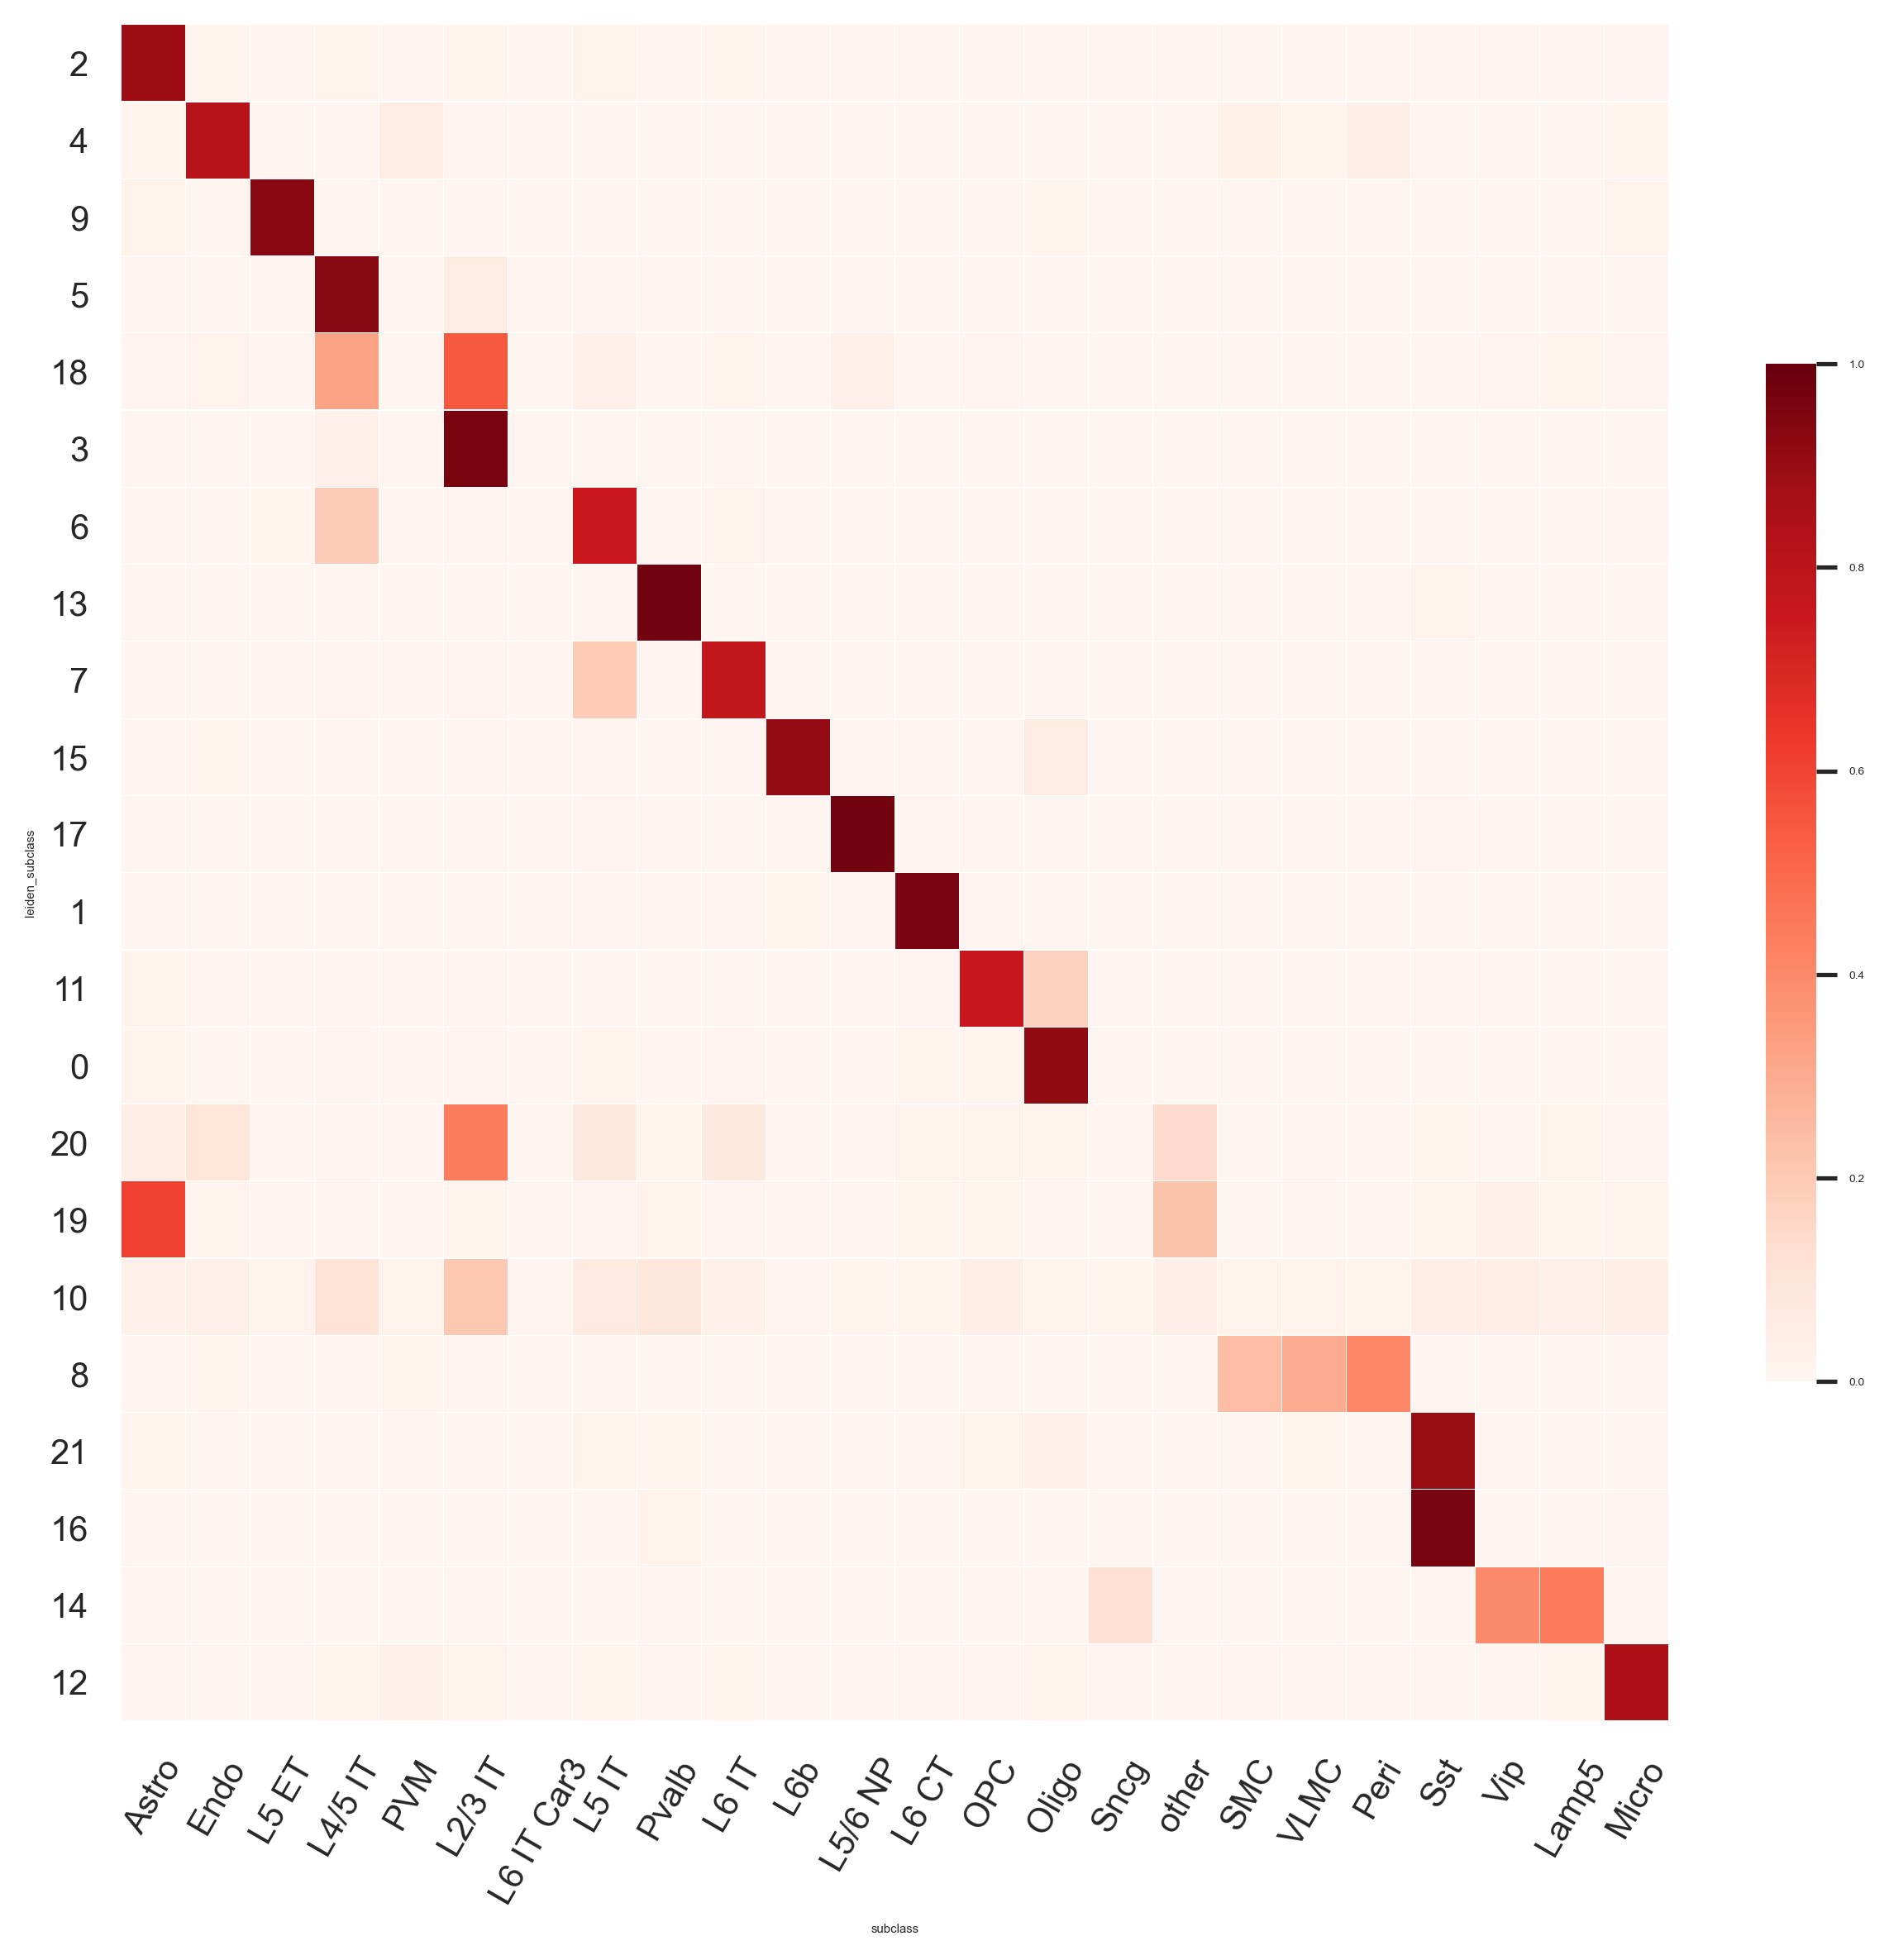

In [58]:
prediction_column = 'subclass_prediction_label'

ref_cluster_column = 'subclass'

query_cluster_column = 'leiden_subclass'
#query_cluster_column = 'leiden_cluster'



print('Predict cell types.')
predict_classes(nnc, adata_query, prediction_column, genes)
    
# Count predictions
prediction_counts = adata_query.obs[[query_cluster_column, prediction_column]]
prediction_counts['count'] = 1
    
predictionMatrix = pd.pivot_table(prediction_counts, index=[query_cluster_column],
               columns=[prediction_column], values='count', aggfunc=np.sum).fillna(0)

predictionMatrix['total'] = predictionMatrix.sum(axis = 1)
    
fractions = predictionMatrix.iloc[:,:-1].div(predictionMatrix['total'],axis = 0)
    
#fractions_sorted, rows, columns = runPermutation(fractions,'Columns')
fractions_sorted, rows, columns = runPermutation(fractions,'Both')
    
# Plot
fig1=plt.figure(figsize = (10,9))
sns.set(font_scale=0.3)
#sns.heatmap(fractions_sorted, cmap='Greys', vmin=0, vmax=1, cbar=True, linewidths=.05,cbar_kws={"shrink": .6})
    
sns.heatmap(fractions_sorted, cmap='Reds', vmin=0, vmax=1, cbar=True, linewidths=.05,cbar_kws={"shrink": .6})
    
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=10)   
plt.xticks(rotation = 60)
plt.yticks(rotation = 'horizontal')
plt.xlabel(ref_cluster_column) 
plt.ylabel(query_cluster_column)
plt.show()

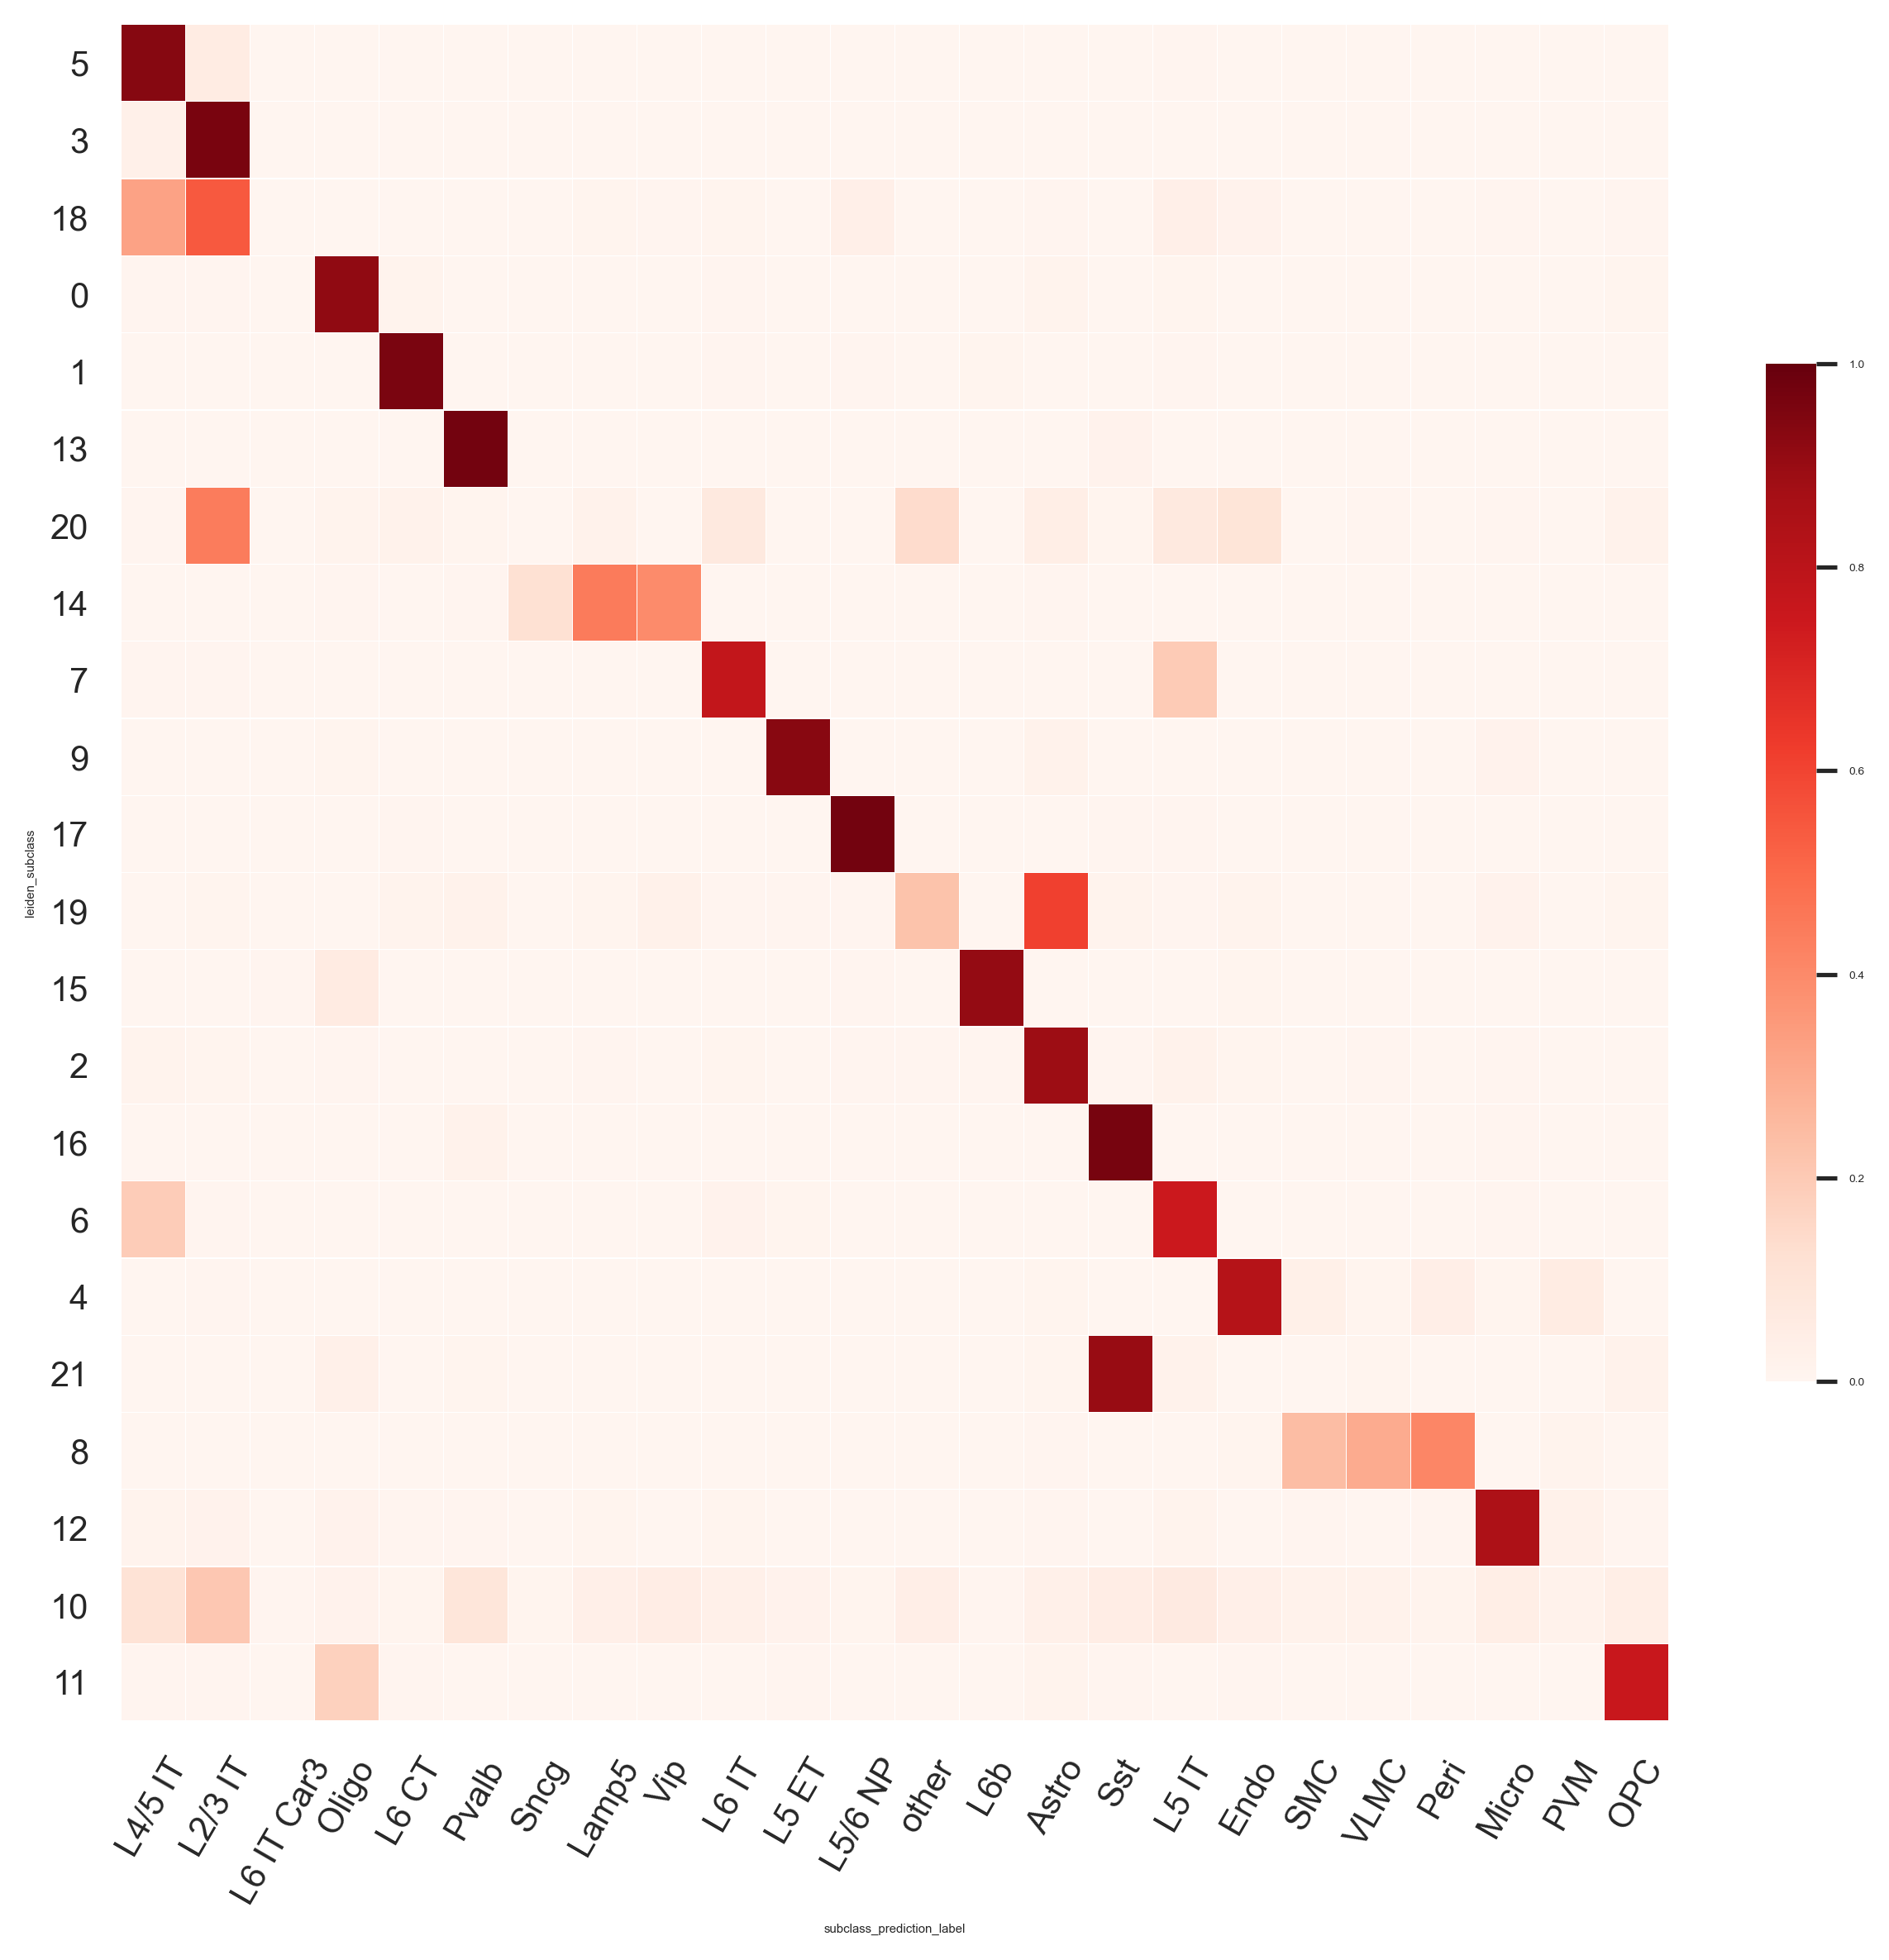

In [59]:
# sort the labels along the x-axis (optional)

sorted_predicted_labels = ['Lamp5','Sncg','Vip','Sst','Pvalb','L2/3 IT','L4/5 IT','L5 IT',
                          'L6 IT','L6 IT Car3','L5 ET','L5/6 NP','L6 CT','L6b','Astro','OPC','Oligo','Endo','VLMC','SMC','Peri',
                         'Micro','PVM','other']

fractions_sorted_by_label = fractions_sorted[sorted_predicted_labels]

sorted_coor_df, rows, columns = runPermutation(fractions_sorted_by_label,'Both',maxIter = 100,maxTrys = 15)

manual_coor_df = sorted_coor_df


_plot = True
if _plot:
   # Plot
    fig1=plt.figure(figsize = (10,9))
    sns.set(font_scale=0.3)
    #sns.heatmap(fractions_sorted, cmap='Greys', vmin=0, vmax=1, cbar=True, linewidths=.05,cbar_kws={"shrink": .6})
    
    sns.heatmap(manual_coor_df, cmap='Reds', vmin=0, vmax=1, cbar=True, linewidths=.05,cbar_kws={"shrink": .6})
    
    plt.tick_params(axis='x', labelsize=10)
    plt.tick_params(axis='y', labelsize=10)
    
    plt.xticks(rotation = 60)
    plt.yticks(rotation = 'horizontal')
    
    
    #plt.xlabel(sorted_coor_df.columns) 
    #plt.ylabel(sorted_coor_df.index)
    plt.show()

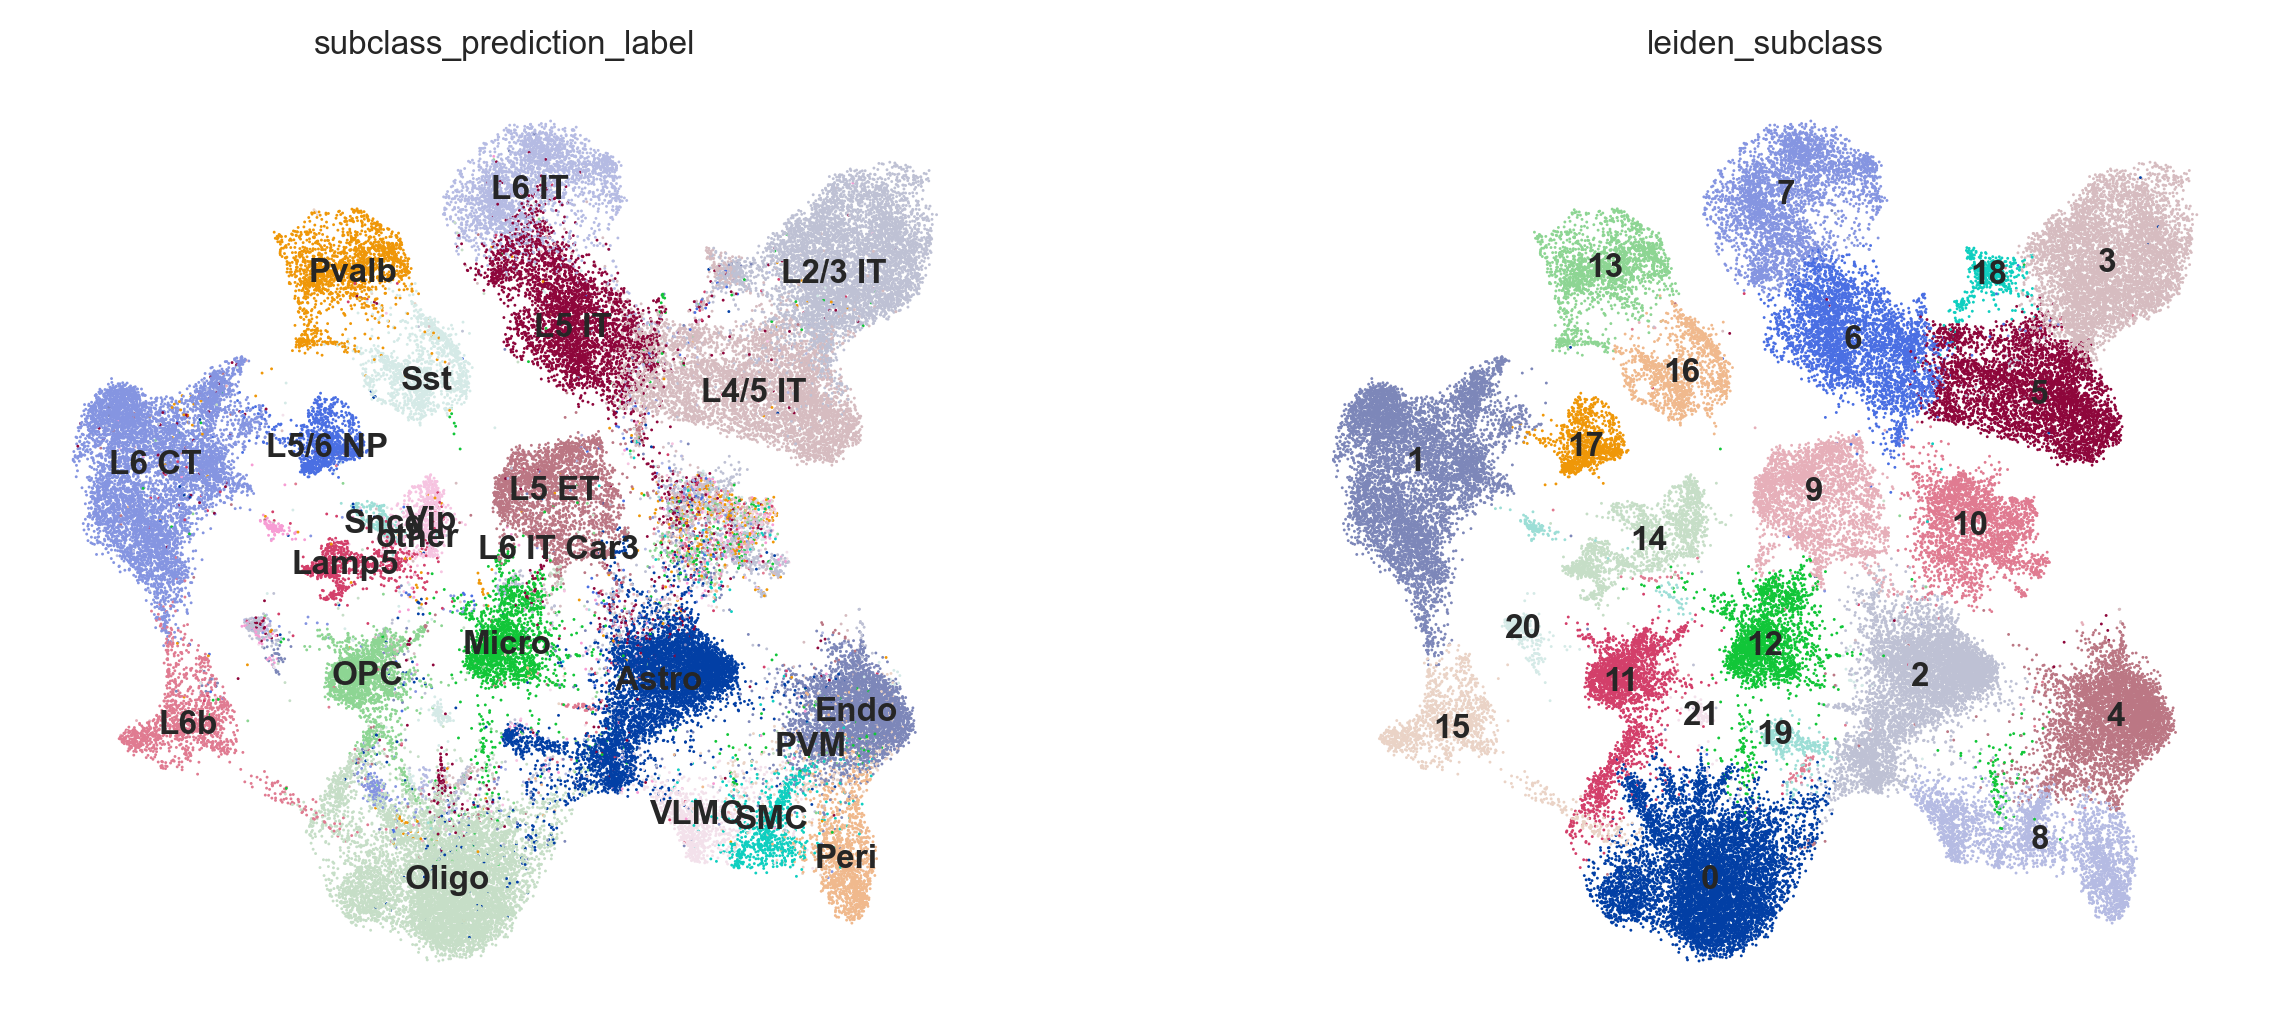

In [61]:
# Plot the predicted labels on UMAP to guide the manual labeling of the de novo clustering below
# use this to manually merge and split the original query column (e.g., leiden_subclass)
sc.settings.n_jobs = 24
#sc.settings.figdir = postanalysis_folder
sc.settings.set_figure_params(dpi=150, dpi_save=300, frameon=False, 
                              figsize=(4, 4), fontsize=8, facecolor='white',)

sc.pl.umap(merged_adata, color=['subclass_prediction_label',query_cluster_column], legend_loc='on data')

# 4. Split labels based on intial prediction

by comparing two UMAP above, we could estimate which cluster should be further splitted

In [77]:
print(query_cluster_column)
merged_adata.obs['leiden_subclass_sub'] = merged_adata.obs[query_cluster_column].copy()
# manual split
# split the CGE inhibitory neurons
sc.tl.leiden(merged_adata, resolution=0.1, restrict_to=('leiden_subclass_sub',['8']), key_added='leiden_subclass_sub')
# split the VLMC-SMC_Peri
sc.tl.leiden(merged_adata, resolution=0.1, restrict_to=('leiden_subclass_sub',['14']), key_added='leiden_subclass_sub')



leiden_subclass


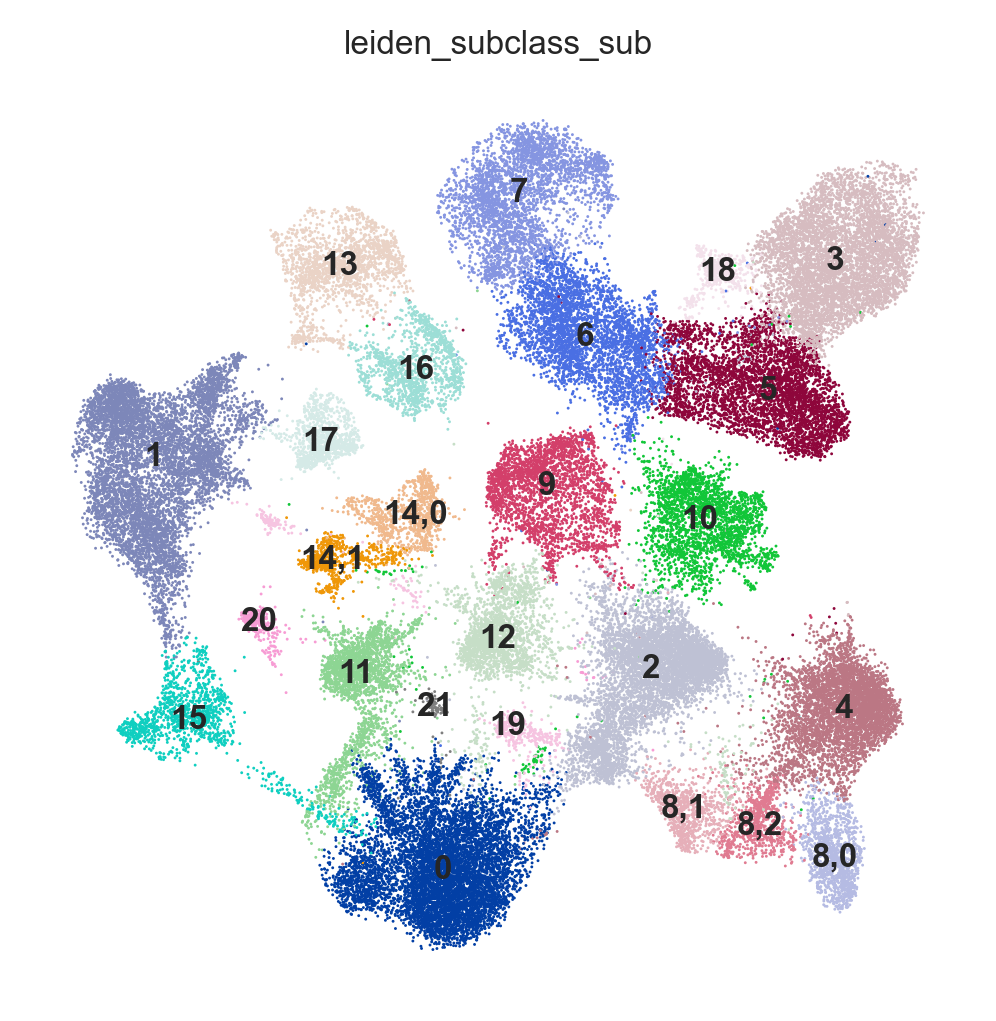

In [78]:
sc.pl.umap(merged_adata, color='leiden_subclass_sub', legend_loc='on data', cmap='Spectral')

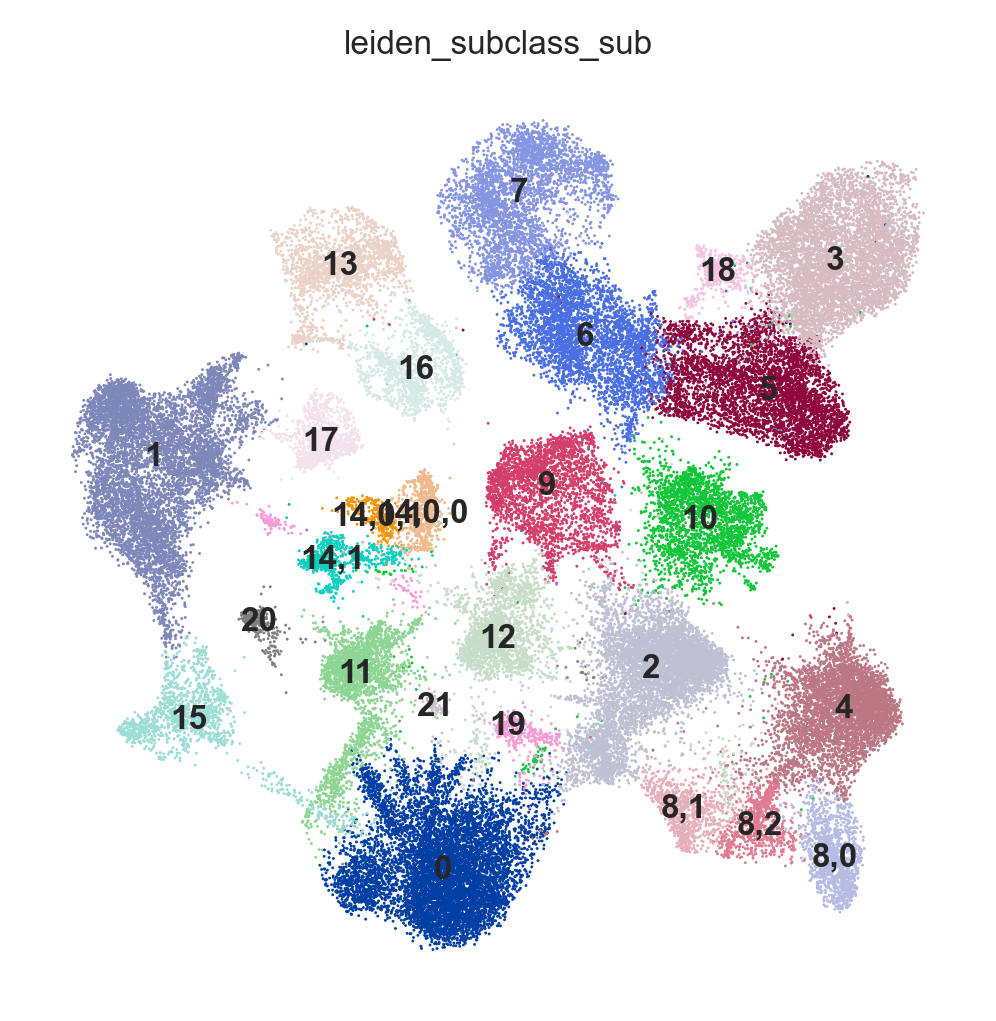

In [79]:
# Further split the Sncg and Vip 
sc.tl.leiden(merged_adata, resolution=0.1, restrict_to=('leiden_subclass_sub',['14,0']), key_added='leiden_subclass_sub')
sc.pl.umap(merged_adata, color='leiden_subclass_sub', legend_loc='on data', cmap='Spectral')

## 4.1 further predict splitted groups

In [82]:
prediction_column = 'subclass_prediction_label'

ref_cluster_column = 'subclass'

# determine which class to query
fine_query_cluster_column = 'leiden_subclass_sub'
#fine_query_cluster_column = 'leiden_cluster'

print('Predict cell types.')
predict_classes(nnc, merged_adata, prediction_column, genes)
 
    
## Count predictions
prediction_counts = merged_adata.obs[[fine_query_cluster_column, prediction_column]]
prediction_counts['count'] = 1

predictionMatrix = pd.pivot_table(prediction_counts, index=[fine_query_cluster_column],
               columns=[prediction_column], values='count', aggfunc=np.sum).fillna(0)

predictionMatrix['total'] = predictionMatrix.sum(axis = 1)
    
fractions = predictionMatrix.iloc[:,:-1].div(predictionMatrix['total'],axis = 0)
    
#fractions_sorted, rows, columns = clsf.runPermutation(fractions,'Columns')
fractions_sorted, rows, columns = runPermutation(fractions,'Both')

Predict cell types.


<ipython-input-82-abff1b1e0723>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_counts['count'] = 1


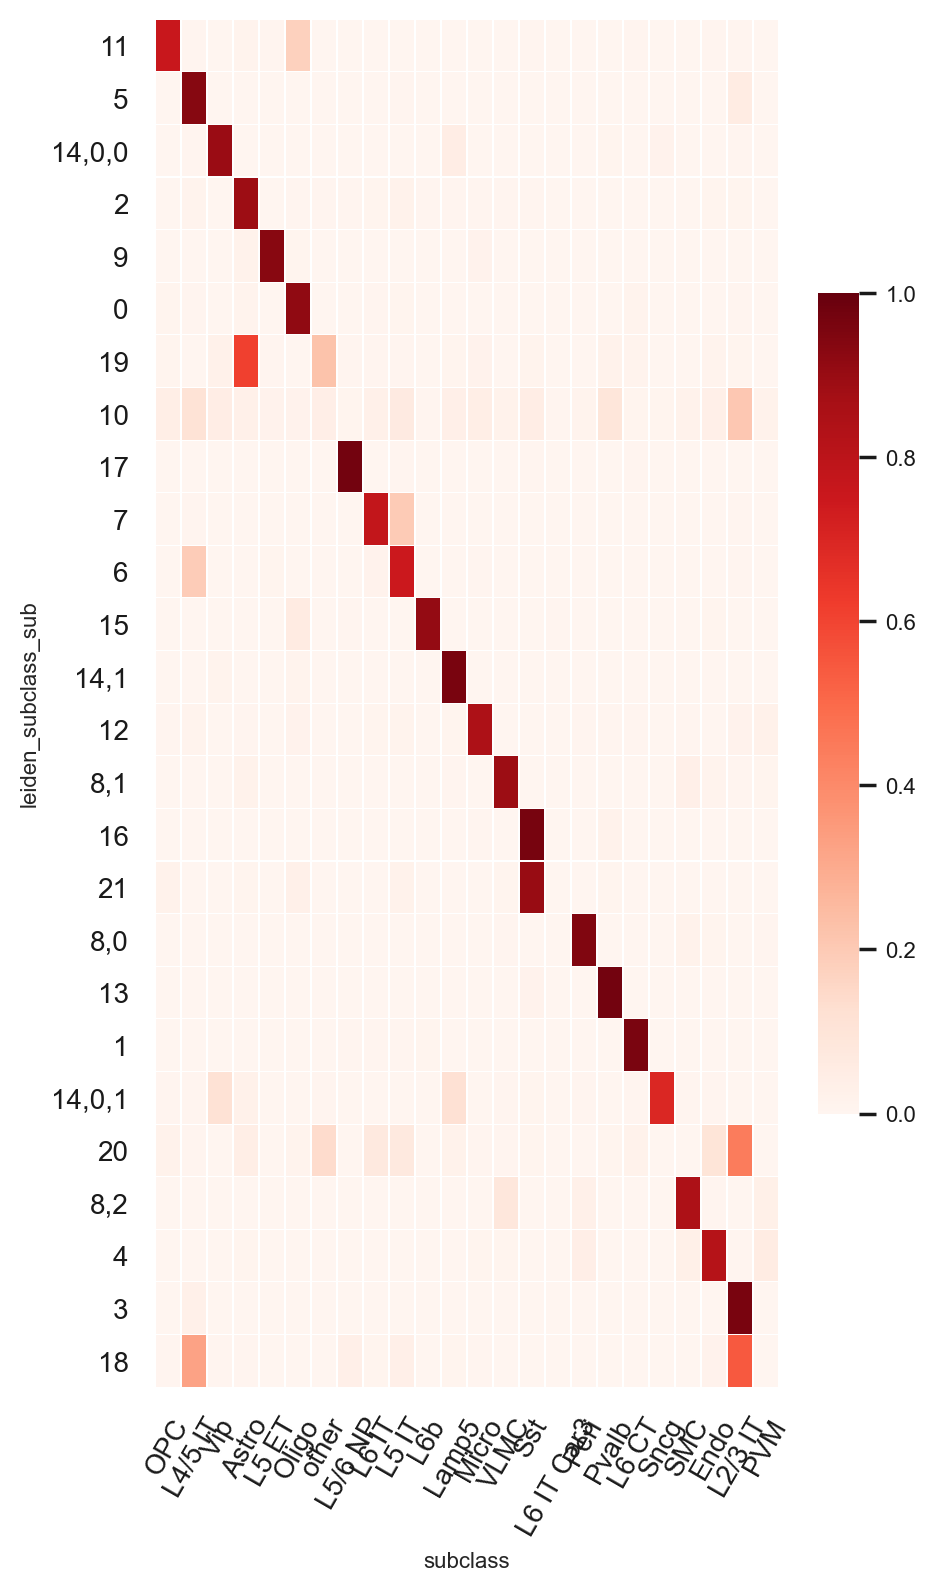

In [83]:
# Plot
fig1=plt.figure(figsize = (5,9), dpi=100)
sns.heatmap(fractions_sorted, cmap='Reds', vmin=0, vmax=1, cbar=True, linewidths=.05,cbar_kws={"shrink": .6})
    
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=10)   
plt.xticks(rotation = 60)
plt.yticks(rotation = 'horizontal')
plt.xlabel(ref_cluster_column) 
plt.ylabel(fine_query_cluster_column)
plt.show()

# 5. Assign most of uniquely classfied clusters

In [84]:
first_assign_dict = {}
missed_classes = []
# Automatic assign best fit if applicable
assign_th = 0.6
for _cluster, _vec in fractions.iterrows():
    #_cluster, _vec
    _matched_inds = np.where(_vec >= assign_th)[0]
    # if uniquely matched:
    if len(_matched_inds) == 1:
        print(_cluster, list(_vec.keys())[_matched_inds[0]])
        first_assign_dict[_cluster] = list(_vec.keys())[_matched_inds[0]]
    else:
        missed_classes.append(_cluster)

0 Oligo
1 L6 CT
2 Astro
3 L2/3 IT
4 Endo
5 L4/5 IT
6 L5 IT
7 L6 IT
8,0 Peri
8,1 VLMC
8,2 SMC
9 L5 ET
11 OPC
12 Micro
13 Pvalb
14,0,0 Vip
14,0,1 Sncg
14,1 Lamp5
15 L6b
16 Sst
17 L5/6 NP
19 Astro
21 Sst


In [85]:
sc.settings.n_jobs = 24
#sc.settings.figdir = postanalysis_folder
sc.settings.set_figure_params(dpi=150, dpi_save=300, frameon=False, 
                              figsize=(4, 4), fontsize=8, facecolor='white',)

... storing 'subclass_prediction_label' as categorical
... storing 'subclass_manual_label' as categorical


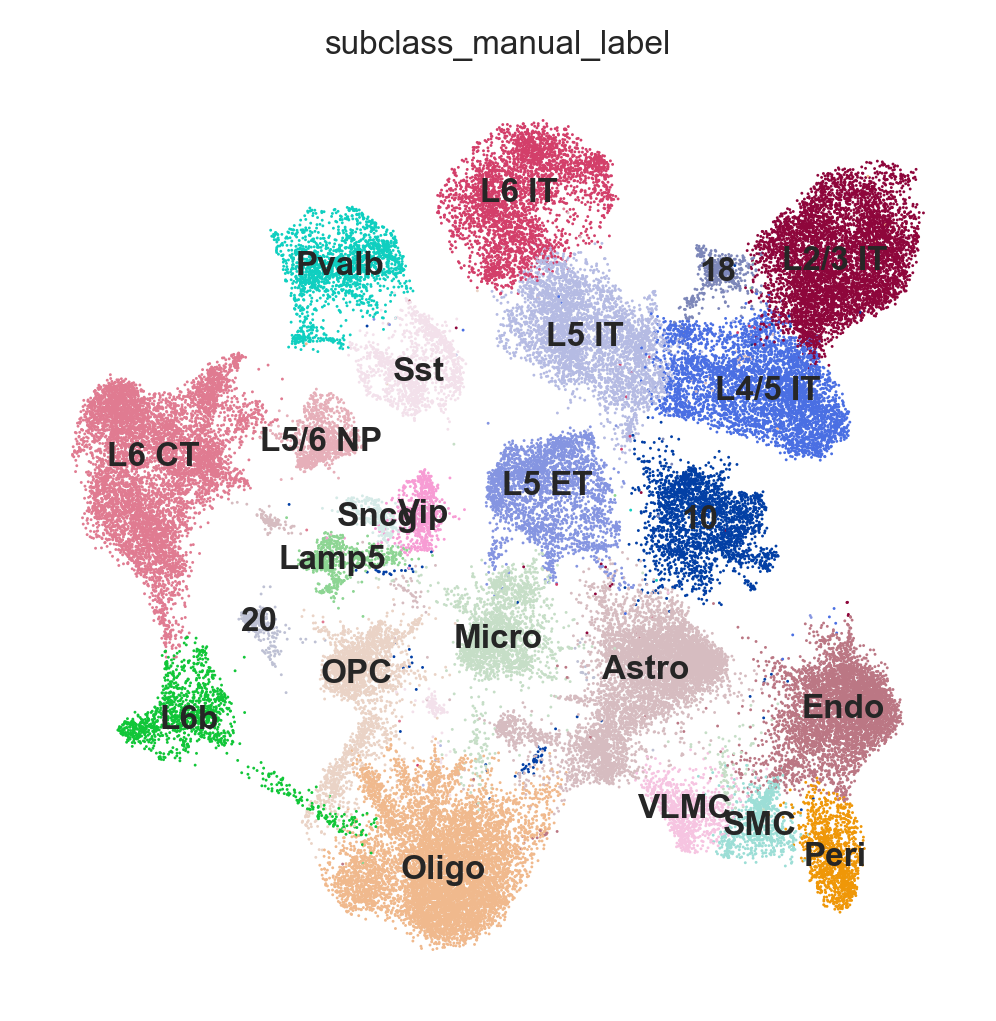

In [86]:
merged_adata.obs['subclass_manual_label'] = merged_adata.obs['leiden_subclass_sub'].copy()
merged_adata.obs = merged_adata.obs.replace({'subclass_manual_label':first_assign_dict})
# Check the leftover
np.unique(merged_adata.obs['subclass_manual_label'])
# Plot the predicted sub-subclass
sc.pl.umap(merged_adata, color='subclass_manual_label', legend_loc='on data',)

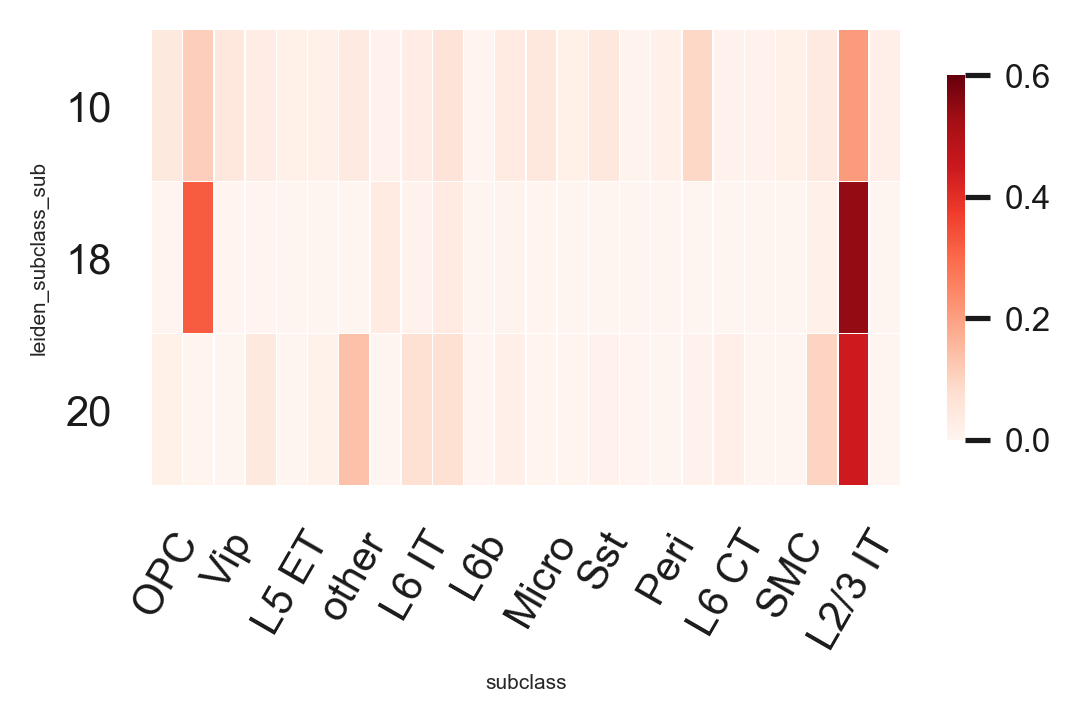

In [87]:
# Plot
fig1=plt.figure(figsize = (4,2), dpi=150)
#sns.set(font_scale=0.25)
#sns.heatmap(fractions_sorted, cmap='Greys', vmin=0, vmax=1, cbar=True, linewidths=.05,cbar_kws={"shrink": .6})
    
sns.heatmap(fractions_sorted.loc[missed_classes], 
            cmap='Reds', vmin=0, vmax=assign_th, cbar=True, linewidths=.05,cbar_kws={"shrink": .8})
    
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=10)   
plt.xticks(rotation = 60)
plt.yticks(rotation = 'horizontal')
plt.xlabel(ref_cluster_column, fontsize=5) 
plt.ylabel(fine_query_cluster_column, fontsize=5)
plt.show()

# 6. Manual assign leftovers

In [88]:
sc.settings.n_jobs = 24
#sc.settings.figdir = postanalysis_folder
sc.settings.set_figure_params(dpi=150, dpi_save=300, frameon=False, 
                              figsize=(4, 4), fontsize=8, facecolor='white',)

In [89]:
print(missed_classes)

for _cls in missed_classes:
    print(_cls)
    print((fractions.loc[_cls].index.values)[np.argsort(fractions.loc[_cls].values)[::-1]][::5])
    print(np.sort(fractions.loc[_cls].values)[::-1][::5])

['10', '18', '20']
10
['L2/3 IT' 'Vip' 'Lamp5' 'VLMC' 'L6 CT']
[0.21000413 0.04754031 0.03555188 0.02108309 0.01116164]
18
['L2/3 IT' 'L6 IT' 'Astro' 'L6b' 'Sncg']
[0.5443787  0.00986193 0.00394477 0.         0.        ]
20
['L2/3 IT' 'Astro' 'Sst' 'L6b' 'Sncg']
[0.44333333 0.04333333 0.01       0.00333333 0.        ]


In [90]:
manual_assign_dict = {
    '18':'L2/3 IT',

}
manual_other_dict = {_c:'other' for _c in missed_classes if _c not in manual_assign_dict}

... storing 'subclass_manual_label' as categorical


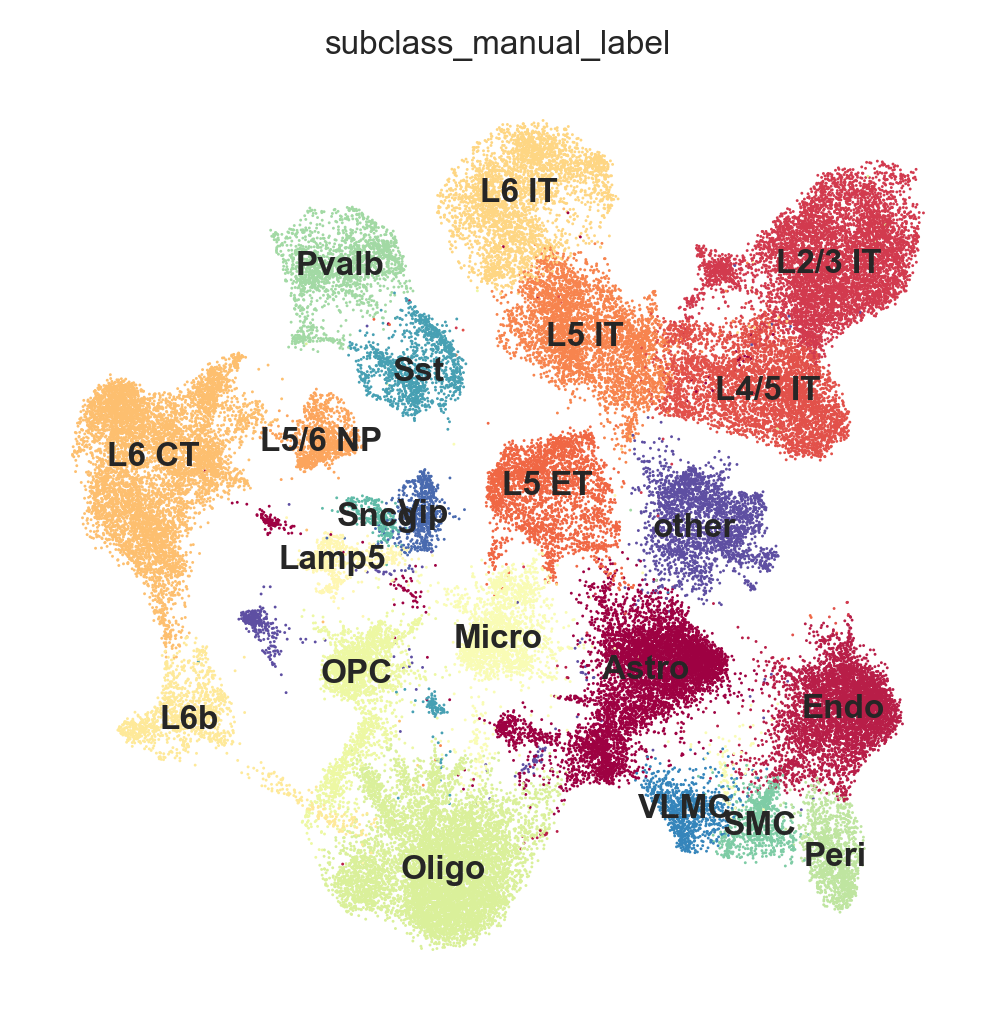

In [91]:
merged_adata.obs = merged_adata.obs.replace({'subclass_manual_label':manual_assign_dict})
merged_adata.obs = merged_adata.obs.replace({'subclass_manual_label':manual_other_dict})
np.unique(merged_adata.obs['subclass_manual_label'])

sc.pl.umap(merged_adata, color='subclass_manual_label', legend_loc='on data', palette='Spectral')

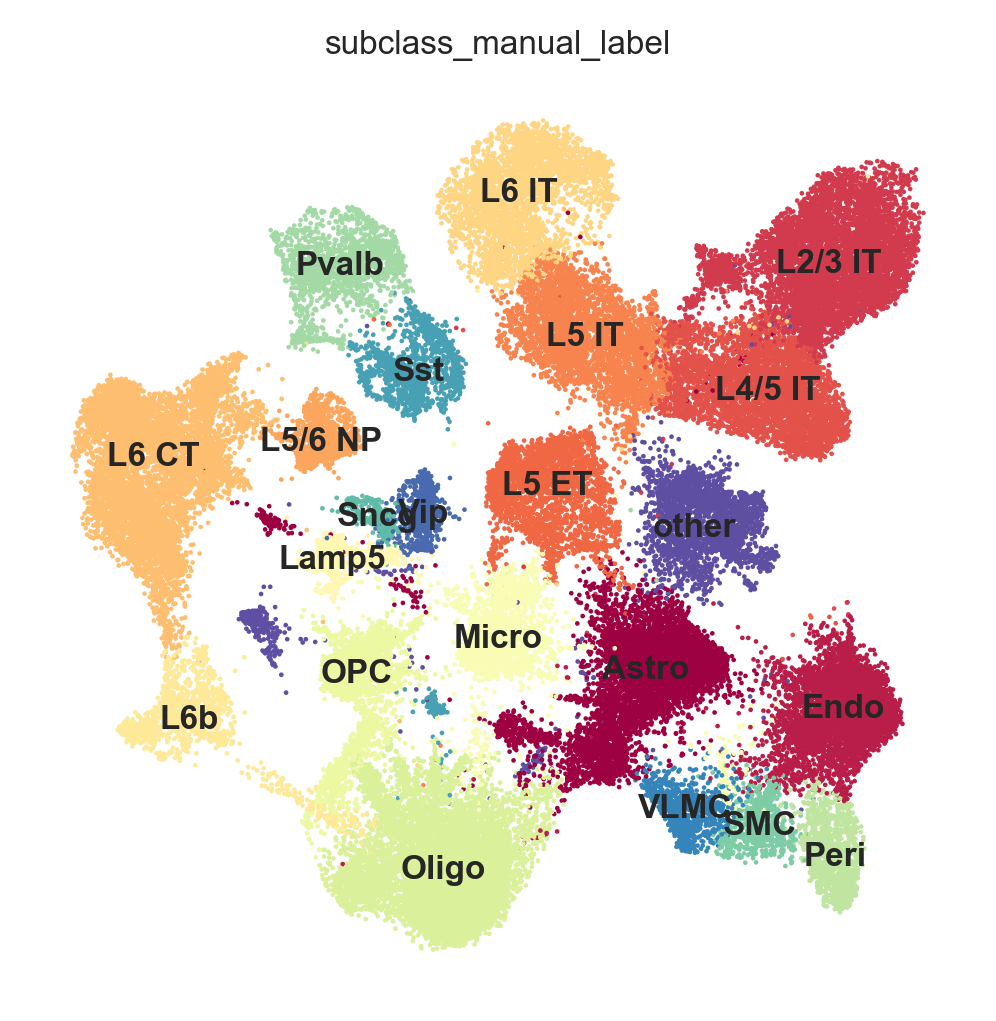

In [92]:
sc.pl.umap(merged_adata, color='subclass_manual_label', legend_loc='on data', size=5,
           cmap='Spectral',
           save='_manual_subclass')
#plt.savefig(os.path.join())

In [93]:
types, counts = np.unique(merged_adata.obs['subclass_manual_label'], return_counts=True)

In [94]:
for _type, _count in zip(types, counts):
    print(_type, _count)

Astro 6473
Endo 4617
L2/3 IT 6035
L4/5 IT 4217
L5 ET 2629
L5 IT 3775
L5/6 NP 991
L6 CT 6944
L6 IT 3281
L6b 1275
Lamp5 643
Micro 2240
OPC 2366
Oligo 7806
Peri 1161
Pvalb 1802
SMC 729
Sncg 248
Sst 1307
VLMC 843
Vip 631
other 2719


<ipython-input-95-a0cf2391a815>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(types, rotation=45)
<ipython-input-95-a0cf2391a815>:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


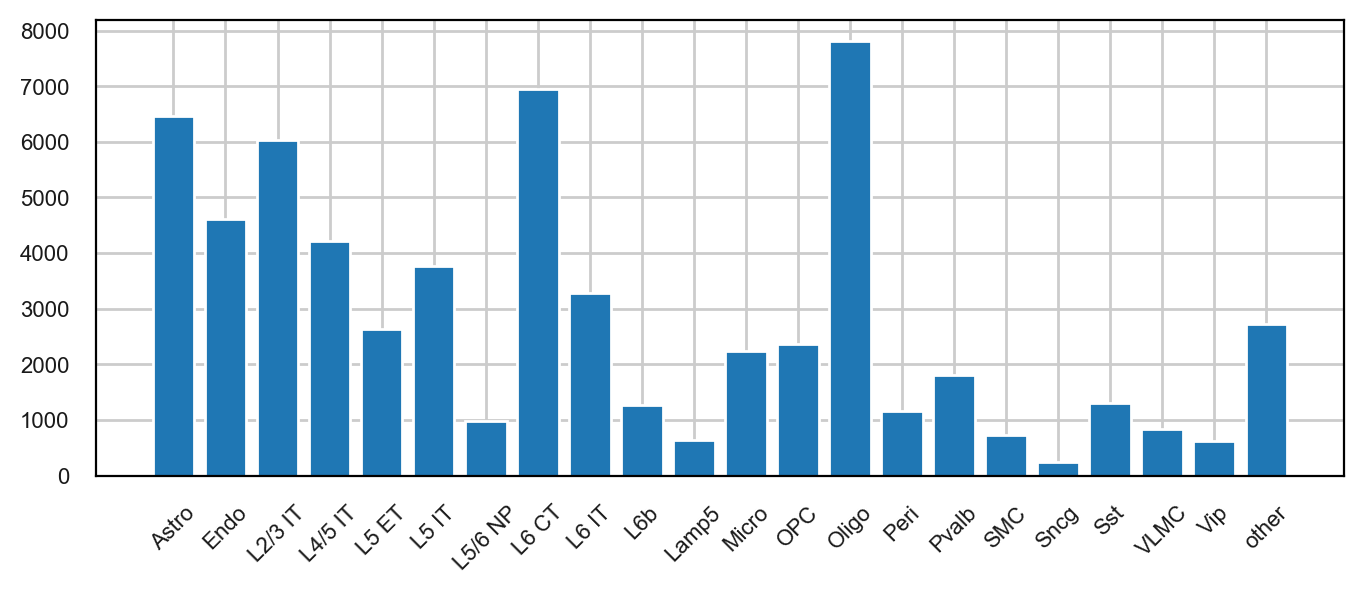

In [95]:
# print class number
fig, ax = plt.subplots(figsize=(8,3), dpi=100)
ax.bar(types, counts)
ax.set_xticklabels(types, rotation=45)
fig.show()

# 7. Redo prediction for manual labels

Check consistency between manual labels vs. predict labels

In [97]:
prediction_column = 'subclass_manual_label_predict'

ref_cluster_column = 'subclass'

# determine which class to query
check_query_cluster_column = 'subclass_manual_label'

print(f'Predict cell types: {check_query_cluster_column}')
predict_classes(nnc, merged_adata, prediction_column, genes)
 
    
## Count predictions
prediction_counts = merged_adata.obs[[check_query_cluster_column, prediction_column]]
prediction_counts['count'] = 1

predictionMatrix = pd.pivot_table(prediction_counts, index=[check_query_cluster_column],
               columns=[prediction_column], values='count', aggfunc=np.sum).fillna(0)

predictionMatrix['total'] = predictionMatrix.sum(axis = 1)
    
fractions = predictionMatrix.iloc[:,:-1].div(predictionMatrix['total'],axis = 0)
    
#fractions_sorted, rows, columns = clsf.runPermutation(fractions,'Columns')
fractions_sorted, rows, columns = runPermutation(fractions,'Both')

Predict cell types: subclass_manual_label


<ipython-input-97-82aa6ea781b1>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_counts['count'] = 1


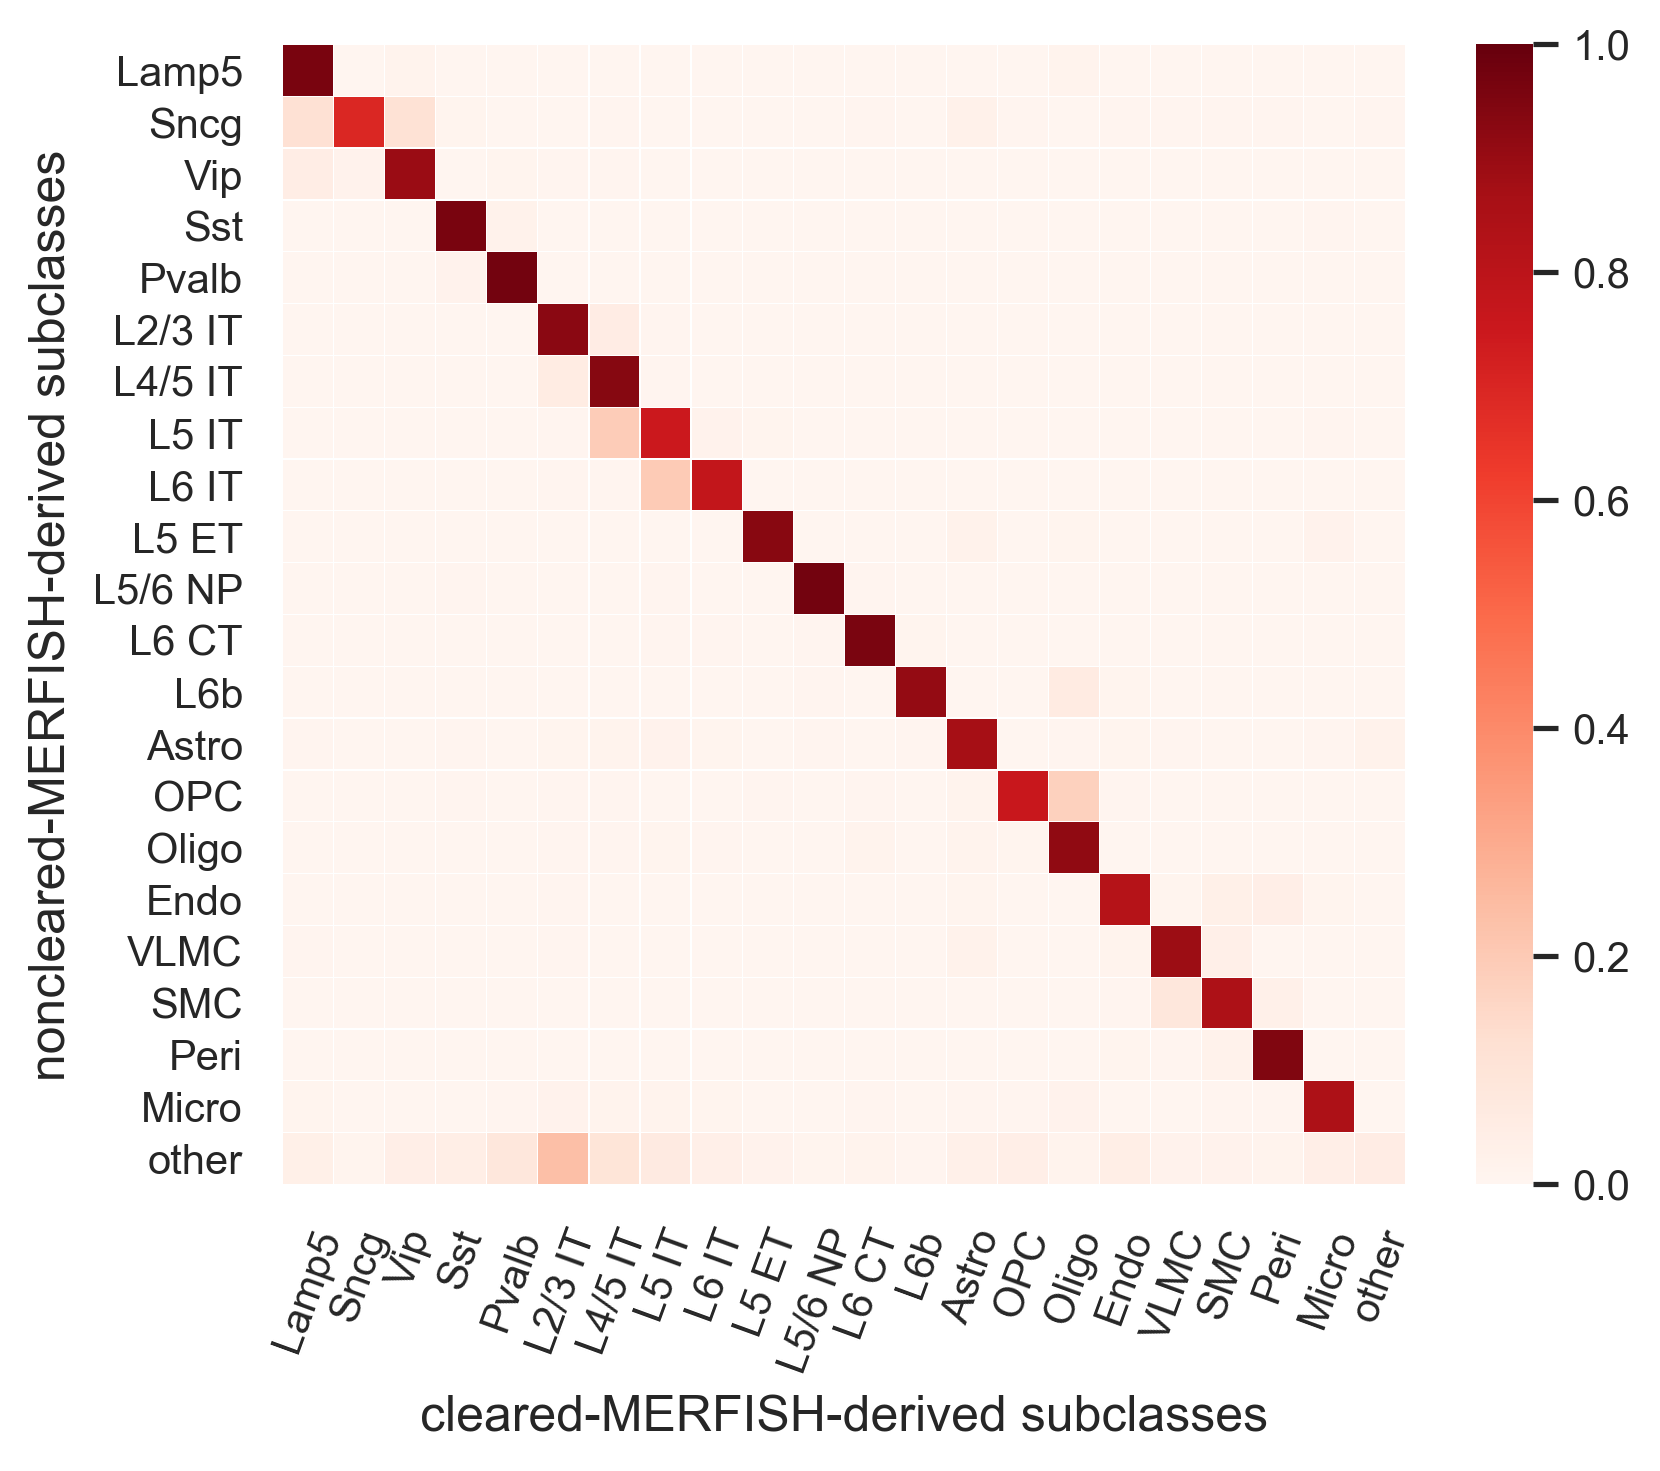

In [111]:
# Plot
fig1=plt.figure(figsize = (6,5))


sorted_predicted_labels = ['Lamp5','Sncg','Vip','Sst','Pvalb','L2/3 IT','L4/5 IT','L5 IT',
                          'L6 IT','L5 ET','L5/6 NP','L6 CT','L6b','Astro','OPC','Oligo','Endo','VLMC','SMC','Peri',
                         'Micro','other']

fractions_sorted = fractions_sorted[sorted_predicted_labels]
fractions_sorted, rows, columns = runPermutation(fractions_sorted_by_label,'Rows',maxIter = 100,maxTrys = 15)



#sns.set(font_scale=0.2)

ax = sns.heatmap(fractions_sorted, cmap='Reds', vmin=0, vmax=1, cbar=True, linewidths=.05,cbar_kws={"shrink": 1})
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=10)

plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=10)   
plt.xticks(rotation = 70)
plt.yticks(rotation = 'horizontal')
#plt.xlabel(ref_cluster_column, size=12) 
#plt.ylabel(check_query_cluster_column, size=12)

plt.xlabel('cleared-MERFISH-derived subclasses', size=12) 
plt.ylabel('noncleared-MERFISH-derived subclasses', size=12)

plt.savefig(os.path.join(figure_folder, 'match_predictClass.pdf'), transparent=True)
plt.show()

# 8. Save manually labeled data

In [112]:
save_filename = os.path.join(os.path.join(save_folder, 'manual_labeled_data.h5ad'))

overwrite = True

if not os.path.exists(save_filename) or overwrite:
    print(f"save merged_adata into file: {save_filename}")
    merged_adata.write(save_filename)
else:
    print(f"savefile: {save_filename} already exists")

... storing 'subclass_manual_label_predict' as categorical


save merged_adata into file: L:\Shiwei\RNA_MERFISH_analysis\Merged_nonclear\manual_labeled_data.h5ad
